In [140]:
from google.colab import files
uploaded=files.upload()

Saving exchange_rate.csv to exchange_rate.csv


                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


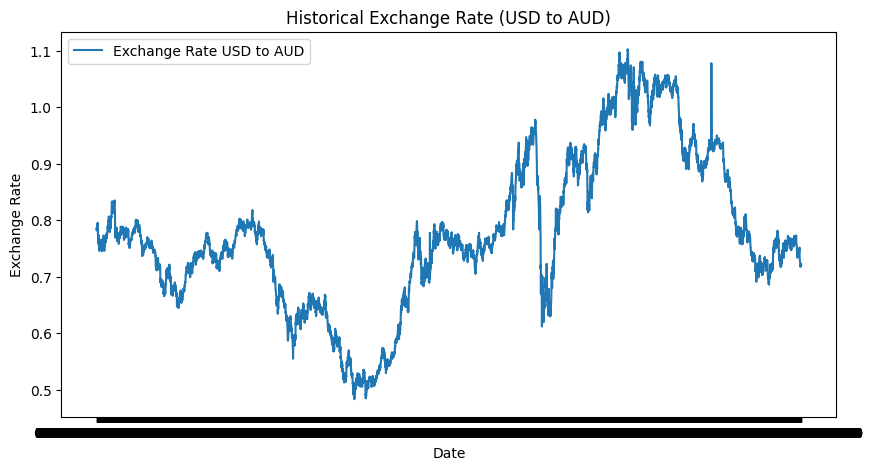

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/exchange_rate.csv"
df = pd.read_csv(file_path, parse_dates=[0], index_col=0)

# Display the first few rows
print(df.head())

# Plot the time series
plt.figure(figsize=(10,5))
plt.plot(df, label="Exchange Rate USD to AUD")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Historical Exchange Rate (USD to AUD)")
plt.legend()
plt.show()


In [155]:
print(df.isnull().sum())
df = df.fillna(method='ffill')


Ex_rate    0
dtype: int64


<ipython-input-155-7257328e26c4>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


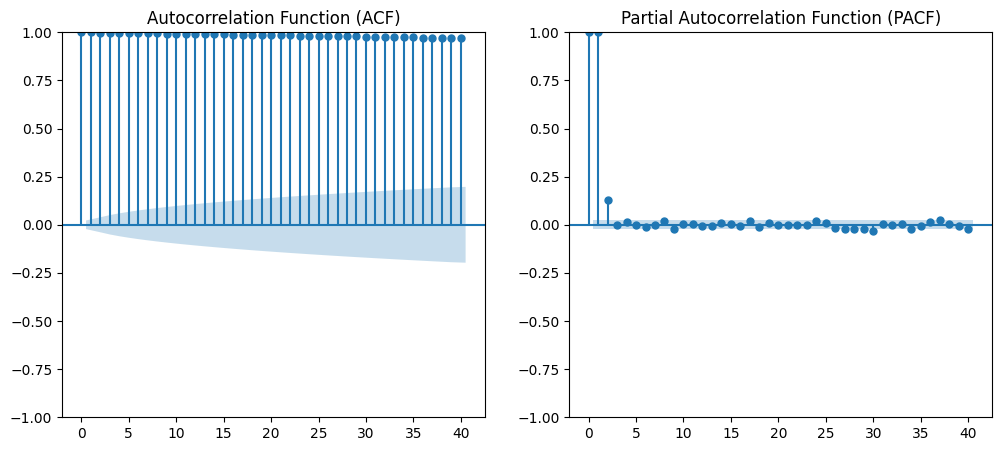

In [156]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to estimate p, d, q
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(df, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(122)
plot_pacf(df, lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()


In [157]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model with estimated p, d, q values (example: p=1, d=1, q=1)
model = ARIMA(df, order=(1,1,1))

# Fit the model
arima_result = model.fit()

# Print model summary
print(arima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 16 Feb 2025   AIC                         -56102.322
Time:                        08:05:30   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


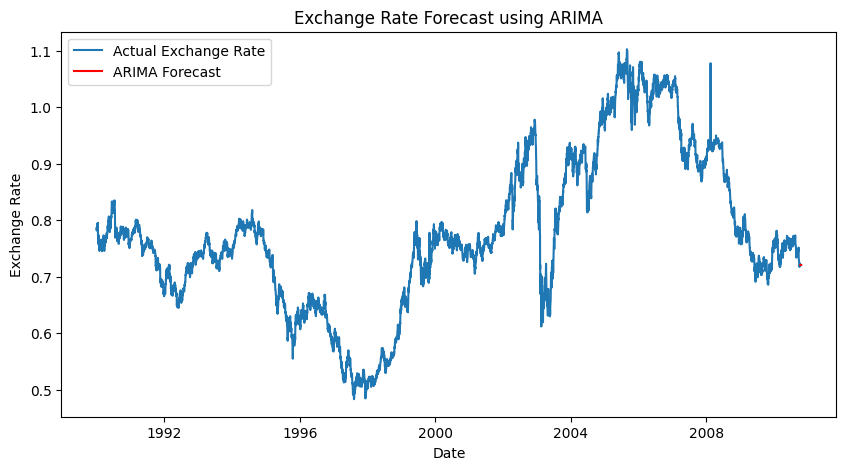

In [162]:
# Forecast next 10 days
forecast_arima = arima_result.forecast(steps=10)

# Convert df.index to a DatetimeIndex if it's not already, specifying the format
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M') # Specifying the correct format

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(df, label="Actual Exchange Rate")

# Generate date range using the last date in the index
last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=11, freq='D')[1:]

# Plot the forecast using future_dates
plt.plot(future_dates, forecast_arima, label="ARIMA Forecast", color="red")

plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Exchange Rate Forecast using ARIMA")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


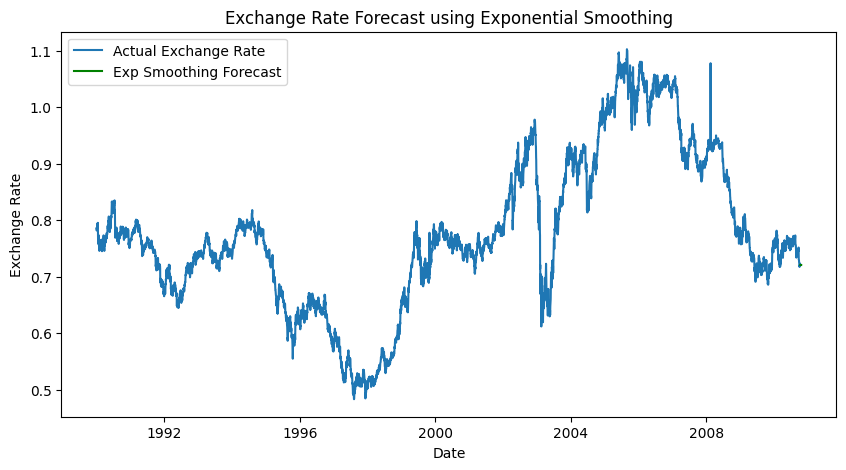

In [163]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model (Holt's Linear Trend Model)
model_exp = ExponentialSmoothing(df, trend="add", seasonal=None)
exp_result = model_exp.fit()

# Forecast next 10 periods
forecast_exp = exp_result.forecast(steps=10)

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(df, label="Actual Exchange Rate")
plt.plot(pd.date_range(df.index[-1], periods=11, freq='D')[1:], forecast_exp, label="Exp Smoothing Forecast", color="green")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Exchange Rate Forecast using Exponential Smoothing")
plt.legend()
plt.show()


In [165]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute error metrics
mae_arima = mean_absolute_error(df[-10:].values.ravel(), forecast_arima) # Convert to 1D array

# Calculate RMSE manually (without the squared parameter)
mse_arima = mean_squared_error(df[-10:].values.ravel(), forecast_arima) # Convert to 1D array
rmse_arima = np.sqrt(mse_arima)

mae_exp = mean_absolute_error(df[-10:].values.ravel(), forecast_exp) # Convert to 1D array

# Calculate RMSE manually (without the squared parameter)
mse_exp = mean_squared_error(df[-10:].values.ravel(), forecast_exp) # Convert to 1D array
rmse_exp = np.sqrt(mse_exp)

print(f"ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")
print(f"Exp Smoothing MAE: {mae_exp:.4f}, RMSE: {rmse_exp:.4f}")

ARIMA MAE: 0.0016, RMSE: 0.0018
Exp Smoothing MAE: 0.0016, RMSE: 0.0019
